In [1]:
import os
import math

import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn

from numpy import load
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from xgboost import XGBClassifier

from sklearn.impute import KNNImputer

from sklearn.svm import SVC

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

rd_seed = 333

## Načtení dat

In [2]:
path_file = os.sep.join(['created_data', 'matrix_semestr_1_personal.csv'])
matrix_bak = pd.read_csv(path_file, sep=",")

## Info o datasetu

In [3]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   studium_id              4005 non-null   int64  
 1   dokoncil_semestr        4005 non-null   float64
 2   pohlavi_kod             4005 non-null   int64  
 3   je_cech                 4005 non-null   int64  
 4   datum_zahajeni          4005 non-null   int64  
 5   rok_maturity            4005 non-null   int64  
 6   maturita_nastup_rozdil  4005 non-null   int64  
 7   gymnazium               4005 non-null   int64  
 8   praha                   4005 non-null   int64  
 9   scio                    4005 non-null   int64  
 10  olym                    4005 non-null   int64  
 11  zkouska                 4005 non-null   int64  
 12  prominuti               4005 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 406.9 KB


In [4]:
matrix_bak.mean()

studium_id                1.468252e+07
dokoncil_semestr          4.444444e-01
pohlavi_kod               1.265918e-01
je_cech                   7.752809e-01
datum_zahajeni            2.017263e+03
rok_maturity              2.016454e+03
maturita_nastup_rozdil    8.092385e-01
gymnazium                 5.458177e-01
praha                     6.516854e-01
scio                      9.712859e-02
olym                      1.036205e-01
zkouska                   3.495630e-02
prominuti                 2.721598e-02
dtype: float64

## Příprava datasetu

### Nastavení indexu

In [5]:
matrix_bak = matrix_bak.set_index(['studium_id'])

### Nastavení target proměnné na nominální

In [6]:
dokoncil_semestr_category = pd.api.types.CategoricalDtype(categories=[0, 1], ordered=False)
matrix_bak['dokoncil_semestr'] = matrix_bak['dokoncil_semestr'].astype(dokoncil_semestr_category)

In [7]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4005 entries, 19374606 to 11740806
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   dokoncil_semestr        4005 non-null   category
 1   pohlavi_kod             4005 non-null   int64   
 2   je_cech                 4005 non-null   int64   
 3   datum_zahajeni          4005 non-null   int64   
 4   rok_maturity            4005 non-null   int64   
 5   maturita_nastup_rozdil  4005 non-null   int64   
 6   gymnazium               4005 non-null   int64   
 7   praha                   4005 non-null   int64   
 8   scio                    4005 non-null   int64   
 9   olym                    4005 non-null   int64   
 10  zkouska                 4005 non-null   int64   
 11  prominuti               4005 non-null   int64   
dtypes: category(1), int64(11)
memory usage: 379.5 KB


### Nastavení atributů na kategorické

In [8]:
# ordinální
attr_category = pd.api.types.CategoricalDtype(categories=[0, 1], ordered=False)
# pohlavi_kod
matrix_bak['pohlavi_kod'] = matrix_bak['pohlavi_kod'].astype(attr_category)
# je_cech
matrix_bak['je_cech'] = matrix_bak['je_cech'].astype(attr_category)
# gymnazium
matrix_bak['gymnazium'] = matrix_bak['gymnazium'].astype(attr_category)
# praha
matrix_bak['praha'] = matrix_bak['praha'].astype(attr_category)
# scio
matrix_bak['scio'] = matrix_bak['scio'].astype(attr_category)
# olym
matrix_bak['olym'] = matrix_bak['olym'].astype(attr_category)
# zkouska
matrix_bak['zkouska'] = matrix_bak['zkouska'].astype(attr_category)
# prominuti
matrix_bak['prominuti'] = matrix_bak['prominuti'].astype(attr_category)

In [9]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4005 entries, 19374606 to 11740806
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   dokoncil_semestr        4005 non-null   category
 1   pohlavi_kod             4005 non-null   category
 2   je_cech                 4003 non-null   category
 3   datum_zahajeni          4005 non-null   int64   
 4   rok_maturity            4005 non-null   int64   
 5   maturita_nastup_rozdil  4005 non-null   int64   
 6   gymnazium               4004 non-null   category
 7   praha                   3206 non-null   category
 8   scio                    4005 non-null   category
 9   olym                    4005 non-null   category
 10  zkouska                 4005 non-null   category
 11  prominuti               4005 non-null   category
dtypes: category(9), int64(3)
memory usage: 161.2 KB


## Modelování

### Bakalář všechny pp

#### Rozdělení datasetu

In [10]:
Xdata = matrix_bak.drop(columns='dokoncil_semestr')
ydata = matrix_bak.dokoncil_semestr

In [11]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.2, random_state=rd_seed, stratify=ydata, shuffle=True) 
print("původní data")
display(Xdata.shape)
display(ydata.shape)
print("trénovací data")
display(Xtrain.shape)
display(ytrain.shape)
print("testovací data")
display(Xtest.shape)
display(ytest.shape)

původní data


(4005, 11)

(4005,)

trénovací data


(3204, 11)

(3204,)

testovací data


(801, 11)

(801,)

#### Funkce pro vybrání vhodných hyperparametrů pomocí křížové validace

In [12]:
def get_best_parameters(param_grid, classifier, xgb=None):
    score = 'f1'
    if xgb:
        model = GridSearchCV(classifier(eval_metric='mlogloss', use_label_encoder=False, tree_method="gpu_hist", enable_categorical=True), param_grid, cv=5, scoring=score)
    else:
        model = GridSearchCV(classifier(), param_grid, cv=5, scoring=score)
    model.fit(Xtrain, ytrain)

    print('Best hyper-parameters are: ')
    print(model.best_params_)
    print()

    means = model.cv_results_["mean_test_score"]
    stds = model.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, model.cv_results_["params"]):
        print("%0.6f (+/-%0.06f) for %r" % (mean, std * 2, params))
    print()
    return model

#### Rozhodovací strom

In [13]:
param_grid = [
    {'criterion':['gini','entropy'],
    'max_depth': range(2,7),
    'min_samples_leaf':[10]}
]

In [14]:
dt_f1 = get_best_parameters(param_grid, DecisionTreeClassifier)

Best hyper-parameters are: 
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10}

0.344440 (+/-0.562576) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10}
0.489631 (+/-0.090016) for {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10}
0.475707 (+/-0.136266) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10}
0.498829 (+/-0.132789) for {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}
0.469655 (+/-0.081755) for {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10}
0.228860 (+/-0.560682) for {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 10}
0.393826 (+/-0.406490) for {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 10}
0.477655 (+/-0.142267) for {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 10}
0.499876 (+/-0.134171) for {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10}
0.477779 (+/-0.092640) for {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10}



In [15]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt_f1.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt_f1.predict(Xtest))))

accuracy score (train): 0.594569
accuracy score (test): 0.561798


In [16]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':dt_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
2,datum_zahajeni,0.679502
3,rok_maturity,0.131131
1,je_cech,0.045868
0,pohlavi_kod,0.040903
5,gymnazium,0.030807
6,praha,0.028174
8,olym,0.019086
4,maturita_nastup_rozdil,0.017469
7,scio,0.007058
9,zkouska,0.000000


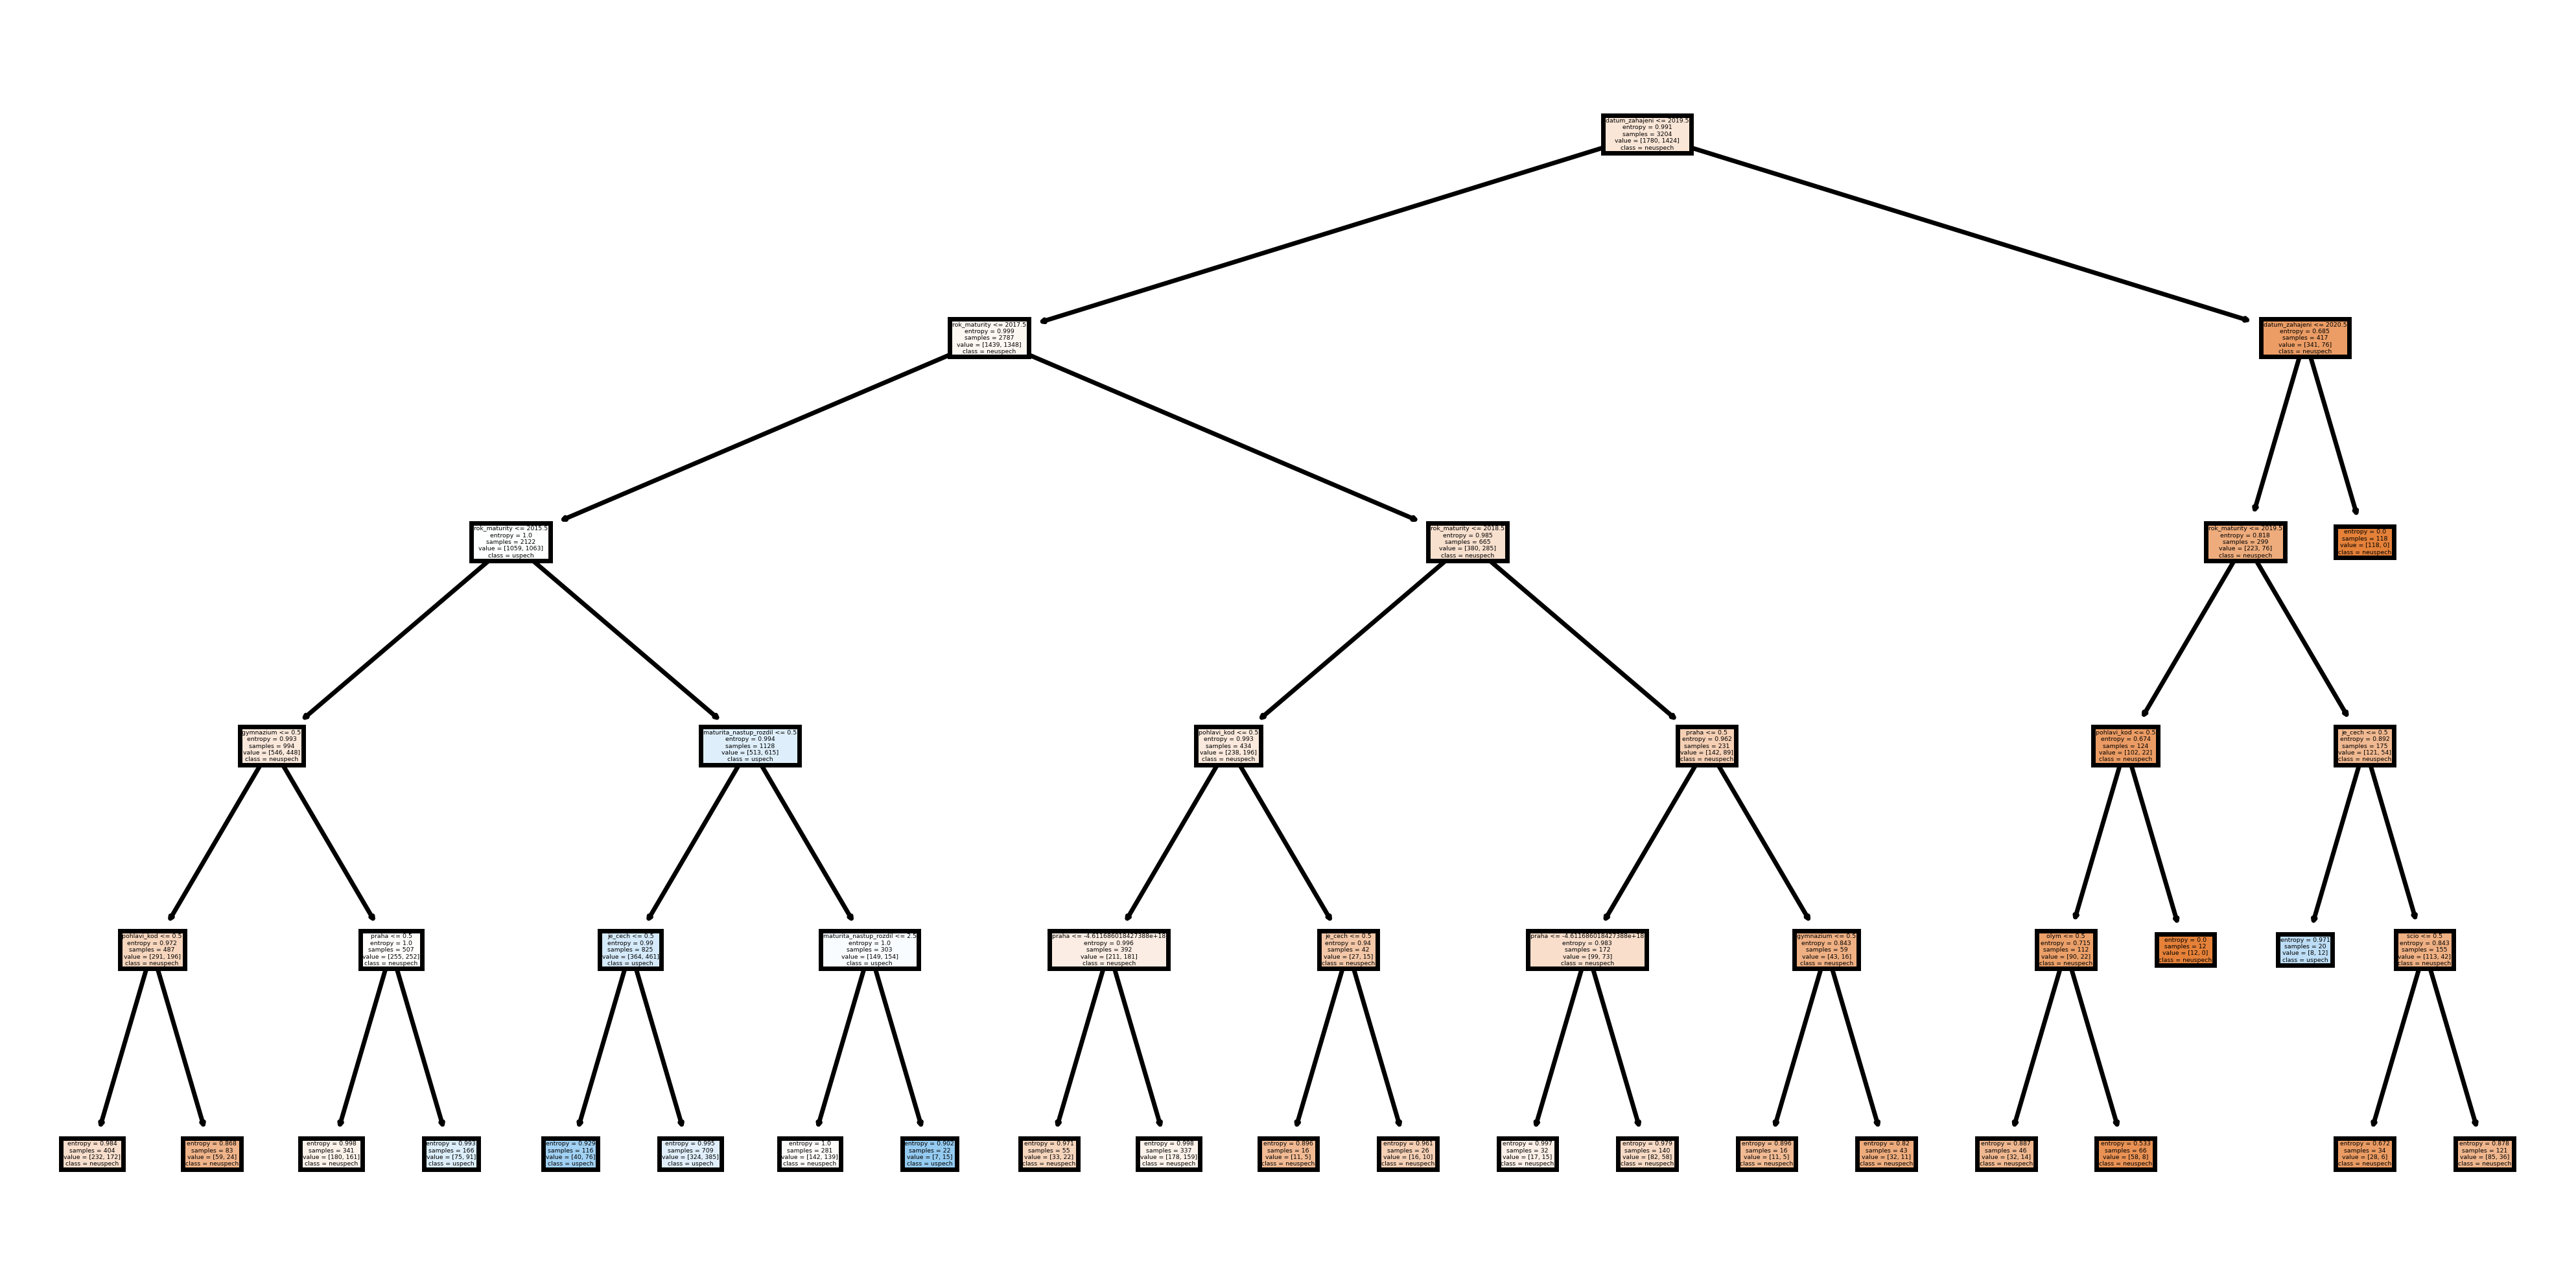

In [17]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5), dpi=500)
tree.plot_tree(dt_f1.best_estimator_,
               feature_names = Xdata.columns, 
               class_names=['neuspech', 'uspech'],
               filled = True);
fig.savefig('tree_f1_semestr1.png')

#### Random forest

In [18]:
param_grid_rf = {
    'criterion':['gini','entropy'],
    'n_estimators': range(5, 50, 5),
    'max_depth': range(2, 4),
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf':[10]
}

In [19]:
rf_f1 = get_best_parameters(param_grid_rf, RandomForestClassifier)

Best hyper-parameters are: 
{'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'n_estimators': 20}

0.101188 (+/-0.404754) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 5}
0.000000 (+/-0.000000) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 10}
0.034483 (+/-0.137931) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 15}
0.000000 (+/-0.000000) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 20}
0.000000 (+/-0.000000) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 25}
0.000000 (+/-0.000000) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 30}
0.000000 (+/-0.000000) for {'criterion': 'gini', 'max_depth': 2, 'max_

In [20]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, rf_f1.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, rf_f1.predict(Xtest))))

accuracy score (train): 0.589263
accuracy score (test): 0.564295


In [21]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':rf_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
2,datum_zahajeni,0.811715
3,rok_maturity,0.126768
4,maturita_nastup_rozdil,0.034974
5,gymnazium,0.010308
0,pohlavi_kod,0.008033
6,praha,0.004429
7,scio,0.001630
1,je_cech,0.001104
9,zkouska,0.001039
8,olym,0.000000


#### Adaboost

In [22]:
param_grid_ab = {
    'n_estimators': range(5, 50, 5),
    'learning_rate': np.arange(0.1, 1., 0.1)
}

In [23]:
ab_f1 = get_best_parameters(param_grid_ab, AdaBoostClassifier)

Best hyper-parameters are: 
{'learning_rate': 0.9, 'n_estimators': 5}

0.000000 (+/-0.000000) for {'learning_rate': 0.1, 'n_estimators': 5}
0.000000 (+/-0.000000) for {'learning_rate': 0.1, 'n_estimators': 10}
0.000000 (+/-0.000000) for {'learning_rate': 0.1, 'n_estimators': 15}
0.087189 (+/-0.348757) for {'learning_rate': 0.1, 'n_estimators': 20}
0.174181 (+/-0.426655) for {'learning_rate': 0.1, 'n_estimators': 25}
0.439916 (+/-0.035779) for {'learning_rate': 0.1, 'n_estimators': 30}
0.438424 (+/-0.031181) for {'learning_rate': 0.1, 'n_estimators': 35}
0.446023 (+/-0.020958) for {'learning_rate': 0.1, 'n_estimators': 40}
0.446023 (+/-0.020958) for {'learning_rate': 0.1, 'n_estimators': 45}
0.000000 (+/-0.000000) for {'learning_rate': 0.2, 'n_estimators': 5}
0.087189 (+/-0.348757) for {'learning_rate': 0.2, 'n_estimators': 10}
0.439916 (+/-0.035779) for {'learning_rate': 0.2, 'n_estimators': 15}
0.447516 (+/-0.025620) for {'learning_rate': 0.2, 'n_estimators': 20}
0.446476 (+/-0.021657

In [24]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, ab_f1.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, ab_f1.predict(Xtest))))

accuracy score (train): 0.586767
accuracy score (test): 0.571785


In [25]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':ab_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
2,datum_zahajeni,0.6
3,rok_maturity,0.4
0,pohlavi_kod,0.0
1,je_cech,0.0
4,maturita_nastup_rozdil,0.0
5,gymnazium,0.0
6,praha,0.0
7,scio,0.0
8,olym,0.0
9,zkouska,0.0


#### Xgboost

In [26]:
param_grid = {
    'eta': np.arange(0.1, 1., 0.1),
    'max_depth': range(3, 8)
}
param_comb = ParameterGrid(param_grid)

In [27]:
xgb_f1 = get_best_parameters(param_grid, XGBClassifier, True)

Best hyper-parameters are: 
{'eta': 0.4, 'max_depth': 4}

0.505129 (+/-0.055982) for {'eta': 0.1, 'max_depth': 3}
0.506092 (+/-0.049552) for {'eta': 0.1, 'max_depth': 4}
0.509415 (+/-0.047315) for {'eta': 0.1, 'max_depth': 5}
0.508209 (+/-0.062455) for {'eta': 0.1, 'max_depth': 6}
0.513998 (+/-0.056133) for {'eta': 0.1, 'max_depth': 7}
0.510794 (+/-0.047703) for {'eta': 0.2, 'max_depth': 3}
0.507429 (+/-0.034364) for {'eta': 0.2, 'max_depth': 4}
0.511439 (+/-0.054121) for {'eta': 0.2, 'max_depth': 5}
0.511957 (+/-0.079445) for {'eta': 0.2, 'max_depth': 6}
0.511597 (+/-0.073176) for {'eta': 0.2, 'max_depth': 7}
0.504185 (+/-0.042622) for {'eta': 0.30000000000000004, 'max_depth': 3}
0.508536 (+/-0.039967) for {'eta': 0.30000000000000004, 'max_depth': 4}
0.508896 (+/-0.077495) for {'eta': 0.30000000000000004, 'max_depth': 5}
0.516270 (+/-0.083240) for {'eta': 0.30000000000000004, 'max_depth': 6}
0.513090 (+/-0.077748) for {'eta': 0.30000000000000004, 'max_depth': 7}
0.503123 (+/-0.029482)

In [28]:
print('accuracy score XGBoost (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, xgb_f1.predict(Xtrain))))
print('accuracy score XGBoost (val): {0:.6f}'.format(metrics.accuracy_score(ytest, xgb_f1.predict(Xtest))))

accuracy score XGBoost (train): 0.633583
accuracy score XGBoost (val): 0.566792


In [29]:
feat_imp = pd.Series(xgb_f1.best_estimator_.get_booster().get_fscore()).sort_values(ascending=False)

In [30]:
feat_imp

maturita_nastup_rozdil    186.0
rok_maturity              178.0
praha                     133.0
datum_zahajeni            117.0
gymnazium                  80.0
je_cech                    78.0
scio                       52.0
olym                       51.0
zkouska                    49.0
pohlavi_kod                46.0
prominuti                  28.0
dtype: float64

#### MLP

In [31]:
mlp = MLPClassifier(random_state=1, max_iter=500).fit(Xtrain, ytrain)

In [32]:
print('accuracy score mlp (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, mlp.predict(Xtrain))))
print('accuracy score mlp (val): {0:.6f}'.format(metrics.accuracy_score(ytest, mlp.predict(Xtest))))

accuracy score mlp (train): 0.445069
accuracy score mlp (val): 0.444444


#### Lineární regrese

In [33]:
reg = LinearRegression().fit(Xtrain, ytrain)

In [34]:
print('RMSE reg (test):', np.sqrt(mean_squared_error(reg.predict(Xtrain), np.array(ytrain))))
print('RMSE reg (test):', np.sqrt(mean_squared_error(reg.predict(Xtest), np.array(ytest))))

RMSE reg (test): 0.4967796120010339
RMSE reg (test): 0.49691273107527006


#### kNN

In [35]:
param_grid = {
    'n_neighbors' : range(1, 12), # Počet nejbližších sousedů
    'p': range(1, 3), # Stupeň Minkowského vzdálenosti
    'weights': ['uniform', 'distance'], # Aritmetický, nebo vážený průměr
}
param_comb = ParameterGrid(param_grid)

In [36]:
knn = get_best_parameters(param_grid, KNeighborsClassifier)

Best hyper-parameters are: 
{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

0.480659 (+/-0.132567) for {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
0.480659 (+/-0.132567) for {'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
0.480659 (+/-0.132567) for {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
0.480659 (+/-0.132567) for {'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
0.304769 (+/-0.108267) for {'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
0.315566 (+/-0.098915) for {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
0.303987 (+/-0.107529) for {'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
0.315566 (+/-0.098915) for {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
0.462783 (+/-0.097450) for {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.459119 (+/-0.091424) for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.463181 (+/-0.098529) for {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.459517 (+/-0.092680) for {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.38

In [37]:
print('accuracy score knn (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, knn.predict(Xtrain))))
print('accuracy score knn (val): {0:.6f}'.format(metrics.accuracy_score(ytest, knn.predict(Xtest))))

accuracy score knn (train): 0.604557
accuracy score knn (val): 0.574282


## Výsledky

In [47]:
results = pd.DataFrame(columns=['vysledky'], index=['dt', 'rf', 'ab', 'xgb', 'mlp', 'knn'])

### Měřeno accuracy_score

In [48]:
results.loc['dt', 'vysledky'] = round(metrics.accuracy_score(ytest, dt_f1.predict(Xtest)), 3)
results.loc['rf', 'vysledky'] = round(metrics.accuracy_score(ytest, rf_f1.predict(Xtest)), 3)
results.loc['ab', 'vysledky'] = round(metrics.accuracy_score(ytest, ab_f1.predict(Xtest)), 3)
results.loc['xgb', 'vysledky'] = round(metrics.accuracy_score(ytest, xgb_f1.predict(Xtest)), 3)
results.loc['mlp', 'vysledky'] = round(metrics.accuracy_score(ytest, mlp.predict(Xtest)), 3)
results.loc['knn', 'vysledky'] = round(metrics.accuracy_score(ytest, knn.predict(Xtest)), 3)

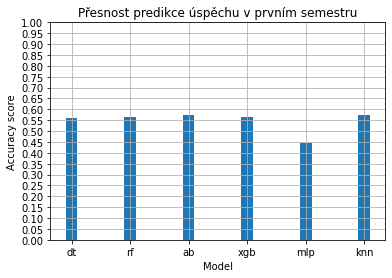

In [51]:
fig, ax = plt.subplots()
width = 0.2
ax.bar(results.index, results['vysledky'].values, width)

ax.set_ylabel('Accuracy score')
ax.set_xlabel('Model')
ax.set_title('Přesnost predikce úspěchu v prvním semestru')

ax.grid(True)
y_values = np.arange(0.0, 1.05, 0.05)
plt.ylim(ymin=0)
plt.ylim(ymax=1)
plt.yticks(y_values)
plt.show()

In [52]:
results

,vysledky
dt,0.562
rf,0.564
ab,0.572
xgb,0.567
mlp,0.444
knn,0.574


### Měřeno f1_score

In [57]:
results_f1 = pd.DataFrame(columns=['vysledky'], index=['dt', 'rf', 'ab', 'xgb', 'mlp', 'knn'])

In [58]:
results_f1.loc['dt', 'vysledky'] = round(metrics.accuracy_score(ytest, dt_f1.predict(Xtest)), 3)
results_f1.loc['rf', 'vysledky'] = round(metrics.accuracy_score(ytest, rf_f1.predict(Xtest)), 3)
results_f1.loc['ab', 'vysledky'] = round(metrics.accuracy_score(ytest, ab_f1.predict(Xtest)), 3)
results_f1.loc['xgb', 'vysledky'] = round(metrics.accuracy_score(ytest, xgb_f1.predict(Xtest)), 3)
results_f1.loc['mlp', 'vysledky'] = round(metrics.accuracy_score(ytest, mlp.predict(Xtest)), 3)
results_f1.loc['knn', 'vysledky'] = round(metrics.accuracy_score(ytest, knn.predict(Xtest)), 3)

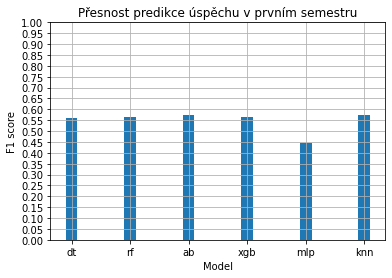

In [59]:
fig, ax = plt.subplots()
width = 0.2
ax.bar(results_f1.index, results_f1['vysledky'].values, width)

ax.set_ylabel('F1 score')
ax.set_xlabel('Model')
ax.set_title('Přesnost predikce úspěchu v prvním semestru')

ax.grid(True)
y_values = np.arange(0.0, 1.05, 0.05)
plt.ylim(ymin=0)
plt.ylim(ymax=1)
plt.yticks(y_values)
plt.show()

In [60]:
results_f1

,vysledky
dt,0.562
rf,0.564
ab,0.572
xgb,0.567
mlp,0.444
knn,0.574
